<a href="https://colab.research.google.com/github/sgr1118/sgr1118/blob/main/%5BExp_03%5D_Kaggle_Challenge_(2019_kaggle_korea).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

In [186]:
# 필요한 라이브러리 임포트하기
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 25)

In [187]:
# 데이터 불러오기 및 날짜 데이터 변환
data = pd.read_csv('train.csv')
sub = pd.read_csv('test.csv')
print(data.shape, sub.shape)
#train.head()

y = data['price']
del data['price']

# train['date'] = train['date'].apply(lambda i : i[:6]).astype(int) # 날짜변환
# test['date'] = test['date'].apply(lambda i : i[:6]).astype(int) # train과 동일한 전처리가 필요

train_len = len(data)
data_con = pd.concat((data, sub), axis=0)
sub_id = data_con['id'][train_len:]
del data_con['id']
data_con.head()

(15035, 21) (6468, 20)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [188]:
# 데이터 결측치 확인
data_con.isnull().sum()
# 결측치는 존재하지 않는 데이터로 확인됨.

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [189]:
# 변수 describe 확인
data_con.describe()
# 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15'
# 이 변수들은 다른 변수들에 mean, min, max 등 값이 매우 큰 것으로 나타나 scaler과정이 예상됨.

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [190]:
# 날짜데이터 변환
data_con['date'] = data_con['date'].apply(lambda x : str(x[:6]))

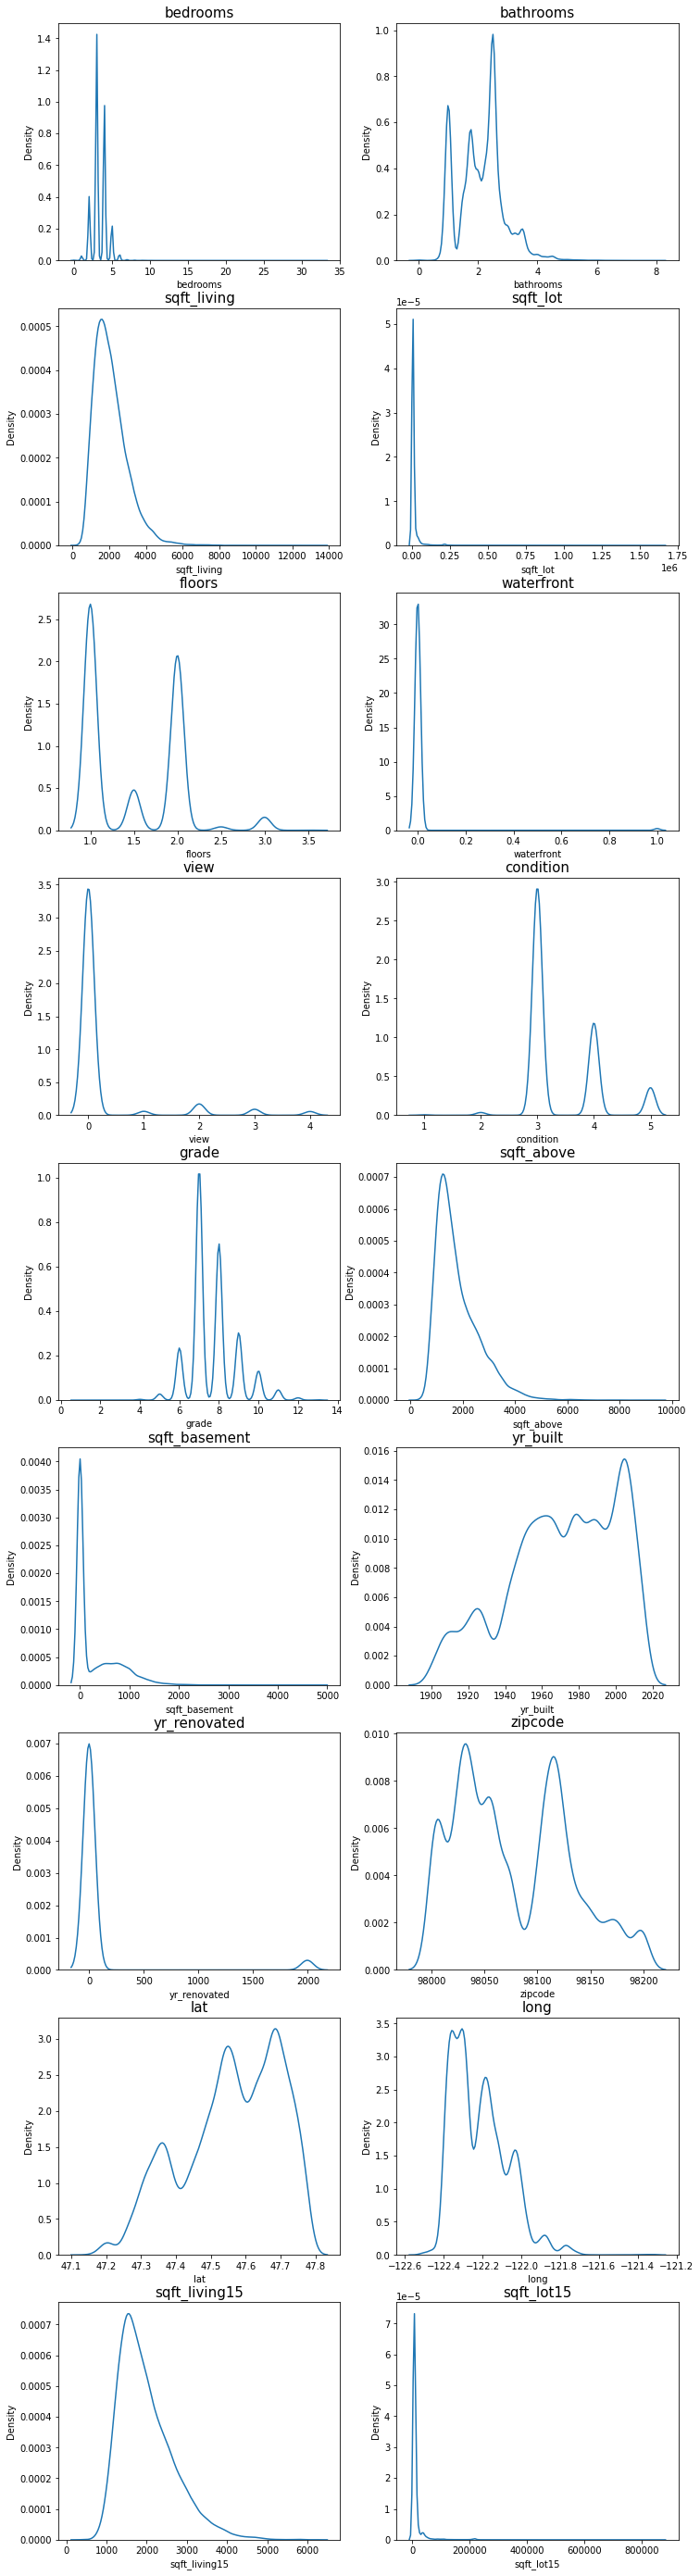

In [6]:
# 데이터 분포를 확인하고 scaler 작업 시행
fig, ax = plt.subplots(9, 2, figsize=(12,50))

count = 1
columns = data_con.columns
for row in range(9):
  for col in range(2):
    sns.kdeplot(data=data_con[columns[count]], ax=ax[row][col])
    ax[row][col].set_title(columns[count], fontsize=15)
    count += 1
    if count == 19 :
      break

# 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15'
# 이 변수들이 치우친 것으로 확인된 sclaer 대상 변수들
# waterfront는 집이 리버뷰 여부를 묻는 변수이므로 scaler 대상이 아니다.

In [67]:
# MinMaxScaler 작업 시행

data_columns = data.columns
scaler = MinMaxScaler()
scaler.fit(data)
data_scaler = scaler.transform(data)

data_minmax = pd.DataFrame(data = data_scaler, columns = data_columns)

In [73]:
# RobustScaler 작업 시행
# skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
data_columns = data.columns
scaler = RobustScaler()
scaler.fit(data)
data_scaler = scaler.transform(data)

data_minmax = pd.DataFrame(data = data_scaler, columns = data_columns)

In [12]:
# log 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
for c in skew_columns:
  data_con[c] = np.log1p(data_con[c].values)

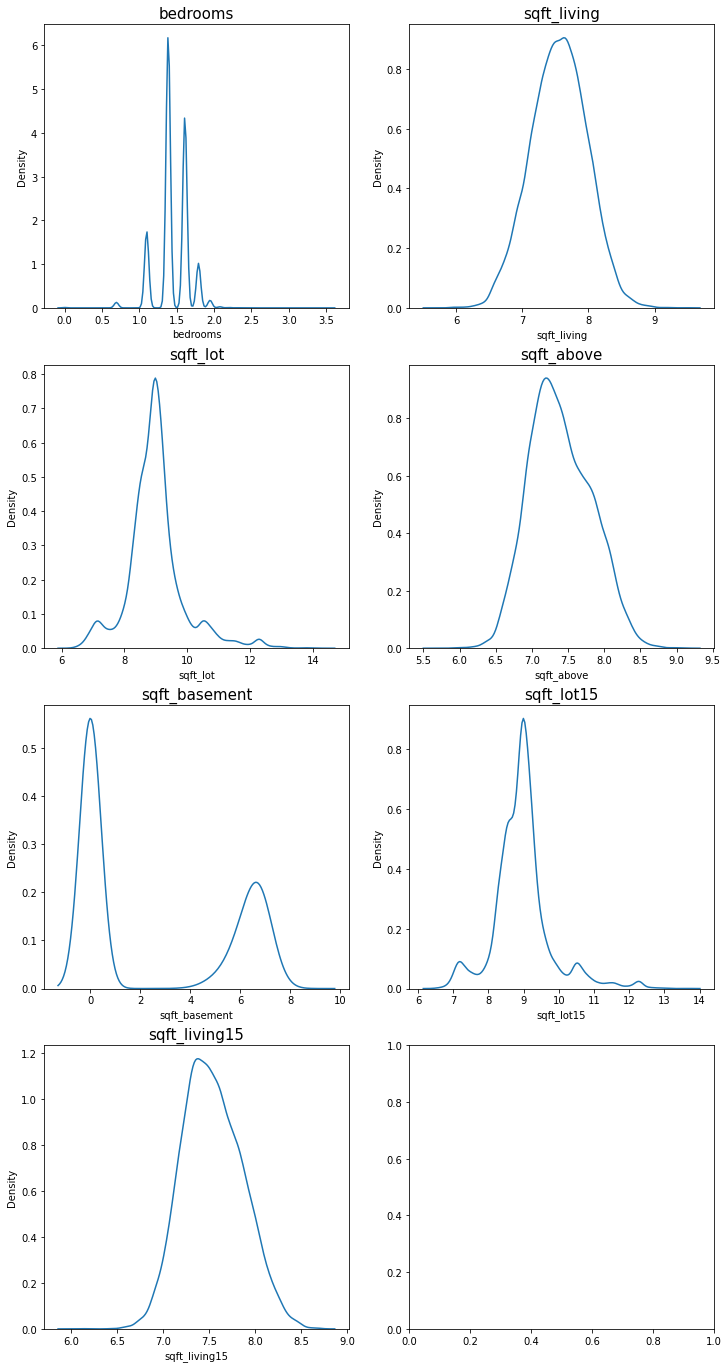

In [13]:
# 로그 변환 후 데이터 분포 다시 확인하기
fig, ax = plt.subplots(4, 2, figsize=(12,24))

count = 0
for row in range(4):
  for col in range(2):
    if count == 7:
      break
    sns.kdeplot(data=data_con[skew_columns[count]], ax=ax[row][col])
    ax[row][col].set_title(skew_columns[count], fontsize=15)
    count += 1

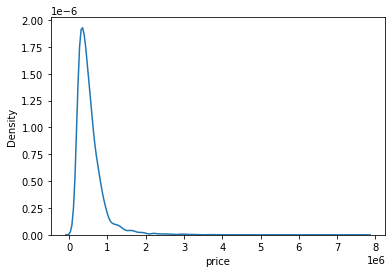

In [9]:
# y값 로그변환
sns.kdeplot(y)
plt.show()


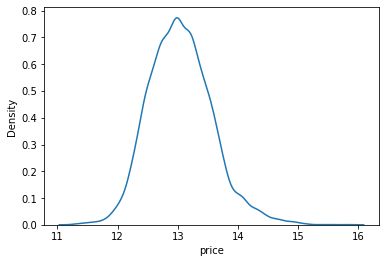

In [10]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [14]:
# train / test 분리
x = data_con.iloc[:train_len, :]
sub= data_con.iloc[train_len:, :]

print(x.shape, sub.shape) # (15035, 19) (6468, 19)

(15035, 19) (6468, 19)


In [15]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = XGBRegressor(random_state=2019)
lightgbm = LGBMRegressor(random_state=2019)
rf = RandomForestRegressor(random_state=2019)
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rf, 'name':'RandomForest'}]

In [16]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [17]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
[06:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819
Model: RandomForest, CV score:0.8696


In [18]:
# 각 모델 예측 결과에 대한 평균
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [19]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[07:17:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([ 542385.66916184,  415766.61110713, 1333695.21557082, ...,
        443699.20102759,  342281.00389456,  420997.06082512])

In [20]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.423857e+05
1,15036,4.157666e+05
2,15037,1.333695e+06
3,15038,3.216200e+05
4,15039,3.034423e+05


In [21]:
result.to_csv('sub.csv', index=False)
# 이 파일은 Score: 118197.48167을 받았다.

# 하이퍼 파라미터를 최적화하여 결과 출력해보기 (lightgbm 사용)

In [131]:
# 데이터 불러오기 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(data.shape, sub.shape)
#train.head()

# 날짜 데이터 변환
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

# y 변수지정 및 컬럼 삭제
y = train['price']
del train['price']
del train['id']
del test['id']

(15035, 20) (6468, 2)


In [128]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

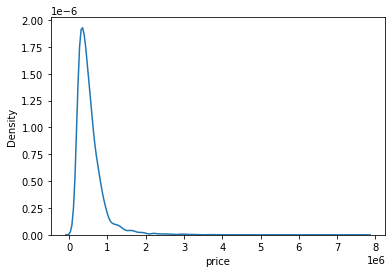

In [132]:
# y 데이터 분포 확인 및 변환
sns.kdeplot(y)
plt.show()

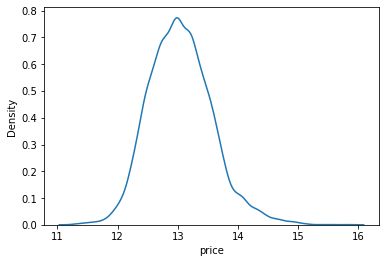

In [133]:
# log변환 시행
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [134]:
def RMSE(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [135]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [136]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = RMSE(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [137]:
 get_scores(models, train, y)
 # 가장 RMSE 점수가 낮은 lightgbm 모델을 사용하기로 결정합니다.

[10:10:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,131067.446228
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359


In [155]:
param_grid = {
    'max_depth': [5, 20],
    'learning_rate' : [0.01, 0.05, 0.2],
    'num_iterations' : [1000, 3000]}

In [156]:
# 학습 모델 선정
model = LGBMRegressor(random_state=random_state)

In [157]:
# 그리스 서치 모델
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.05, 0.2],
                         'max_depth': [5, 20], 'num_iterations': [1000, 3000]},
             scoring='neg_mean_squared_error', verbose=1)

In [158]:
grid_model.cv_results_

{'mean_fit_time': array([ 9.36226897, 25.56317677, 14.28432407, 35.01975932,  9.45692043,
        22.05665812, 11.01699443, 29.81575985, 10.22973456, 21.84130301,
         9.77202926, 27.88679256]),
 'mean_score_time': array([0.89870133, 3.56346617, 1.08230071, 4.75998449, 0.79615116,
        3.49401045, 1.00011082, 5.76126561, 0.79288387, 3.58298135,
        0.91051602, 3.10826545]),
 'mean_test_score': array([-0.02853459, -0.02638226, -0.02669015, -0.02572525, -0.02622637,
        -0.02684802, -0.02604376, -0.02682169, -0.02887677, -0.03021144,
        -0.02876618, -0.0291552 ]),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.05, 0.05, 0.05, 0.05, 0.2,
                    0.2, 0.2, 0.2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 5, 20, 20, 5, 5, 20, 20, 5, 5, 20, 20],
              mask=[

In [159]:
params = grid_model.cv_results_['params']
params

[{'learning_rate': 0.01, 'max_depth': 5, 'num_iterations': 1000},
 {'learning_rate': 0.01, 'max_depth': 5, 'num_iterations': 3000},
 {'learning_rate': 0.01, 'max_depth': 20, 'num_iterations': 1000},
 {'learning_rate': 0.01, 'max_depth': 20, 'num_iterations': 3000},
 {'learning_rate': 0.05, 'max_depth': 5, 'num_iterations': 1000},
 {'learning_rate': 0.05, 'max_depth': 5, 'num_iterations': 3000},
 {'learning_rate': 0.05, 'max_depth': 20, 'num_iterations': 1000},
 {'learning_rate': 0.05, 'max_depth': 20, 'num_iterations': 3000},
 {'learning_rate': 0.2, 'max_depth': 5, 'num_iterations': 1000},
 {'learning_rate': 0.2, 'max_depth': 5, 'num_iterations': 3000},
 {'learning_rate': 0.2, 'max_depth': 20, 'num_iterations': 1000},
 {'learning_rate': 0.2, 'max_depth': 20, 'num_iterations': 3000}]

In [160]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02853459, -0.02638226, -0.02669015, -0.02572525, -0.02622637,
       -0.02684802, -0.02604376, -0.02682169, -0.02887677, -0.03021144,
       -0.02876618, -0.0291552 ])

In [161]:
results = pd.DataFrame(params)
results['score'] = score
results

,learning_rate,max_depth,num_iterations,score
0,0.01,5,1000,-0.028535
1,0.01,5,3000,-0.026382
2,0.01,20,1000,-0.026690
3,0.01,20,3000,-0.025725
4,0.05,5,1000,-0.026226
5,0.05,5,3000,-0.026848
6,0.05,20,1000,-0.026044
7,0.05,20,3000,-0.026822
8,0.20,5,1000,-0.028877
9,0.20,5,3000,-0.030211


In [162]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,learning_rate,max_depth,num_iterations,score,RMSE
0,0.01,5,1000,-0.028535,0.168922
1,0.01,5,3000,-0.026382,0.162426
2,0.01,20,1000,-0.026690,0.163371
3,0.01,20,3000,-0.025725,0.160391
4,0.05,5,1000,-0.026226,0.161946
5,0.05,5,3000,-0.026848,0.163854
6,0.05,20,1000,-0.026044,0.161381
7,0.05,20,3000,-0.026822,0.163773
8,0.20,5,1000,-0.028877,0.169932
9,0.20,5,3000,-0.030211,0.173814


In [163]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,learning_rate,max_depth,num_iterations,score,RMSLE
0,0.01,5,1000,-0.028535,0.168922
1,0.01,5,3000,-0.026382,0.162426
2,0.01,20,1000,-0.026690,0.163371
3,0.01,20,3000,-0.025725,0.160391
4,0.05,5,1000,-0.026226,0.161946
5,0.05,5,3000,-0.026848,0.163854
6,0.05,20,1000,-0.026044,0.161381
7,0.05,20,3000,-0.026822,0.163773
8,0.20,5,1000,-0.028877,0.169932
9,0.20,5,3000,-0.030211,0.173814


In [164]:
# 위의 표를 `RMSLE`가 낮은 순서대로 정렬해주세요.
results = results['RMSLE'].sort_values(ascending=True)
results
# 3번이 가장 예측력이 좋은 것으로 나타남.

3     0.160391
6     0.161381
4     0.161946
1     0.162426
2     0.163371
7     0.163773
5     0.163854
0     0.168922
10    0.169606
8     0.169932
11    0.170749
9     0.173814
Name: RMSLE, dtype: float64

In [185]:
# 가장 성능이 좋았던 파라미터를 넣어서 모델 학습
# model = LGBMRegressor(learning_rate=0.01, max_depth = 20, num_iterations = 3000, random_state=random_state)
model = LGBMRegressor(learning_rate=0.05, max_depth = 20, num_iterations = 3000, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction
# 다른 파라미터 조합들도 여러번 넣어보면서 점수 비교를 하였습니다.

array([13.14981322, 13.08383243, 14.03731154, ..., 13.07336715,
       12.70474043, 12.98757138])

In [182]:
prediction = np.expm1(prediction)
prediction

array([ 499882.73157759,  454056.54061326, 1373216.45626211, ...,
        457880.21021787,  324040.85849909,  423278.46488832])

In [183]:
sub = pd.read_csv('/content/sample_submission.csv')
sub['price'] = prediction
sub.head()

,id,price
0,15035,4.998827e+05
1,15036,4.540565e+05
2,15037,1.373216e+06
3,15038,3.180978e+05
4,15039,3.284230e+05


In [184]:
sub.to_csv('sub_4.csv', index=False)
# 이 파일은 Score: 118197.48167 ~ 109369.30254을 받았다.
# 특이한 점이 1가지 있었습니다.
# RMSLE 값이 가장 낮다고하여 캐글 score값이 가장 낮게나오는 건 아니었다.

# HyperOpt를 사용한 파라미터 최적화 방법 (xgboost 사용)


In [ ]:
# 데이터 불러오기 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(data.shape, sub.shape)
#train.head()

# 날짜 데이터 변환
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

# y 변수지정 및 컬럼 삭제
y = train['price']
del train['price']
del train['id']
del test['id']

(15035, 20) (6468, 19)


In [ ]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

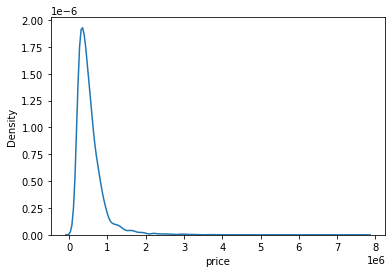

In [ ]:
# y데이터 분포 확인 및 변환
sns.kdeplot(y)
plt.show()

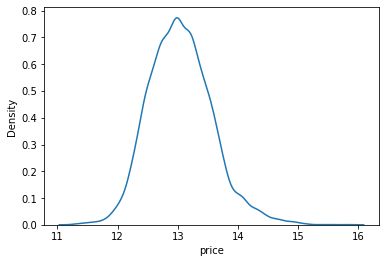

In [ ]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [ ]:
def RMSE(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = RMSE(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [ ]:
 get_scores(models, train, y)
 # 모델별로 RMSE를 출력해보았고 위에서는 LGBMRegressor를 사용했기 때문에 이번에는 XGBRegressor를 사용해보도록 한다.

[09:22:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,131067.446228
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359


In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

In [ ]:
# HyperOpt 함수 구현
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]

space={'max_depth': hp.quniform("max_depth", 5, 15, 1),
       'learning_rate': hp.quniform ('learning_rate', 0.01, 0.05, 0.005),
       'reg_alpha' : hp.choice('reg_alpha', reg_candidate),
       'reg_lambda' : hp.choice('reg_lambda', reg_candidate),
       'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
       'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 1, 0.05),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 200, 1500, 100)}

def hyperparameter_tuning(space):
    model=XGBRegressor(n_estimators =int(space['n_estimators']), 
                       max_depth = int(space['max_depth']), 
                       learning_rate = space['learning_rate'],
                       reg_alpha = space['reg_alpha'],
                       reg_lambda = space['reg_lambda'],
                       subsample = space['subsample'],
                       colsample_bytree = space['colsample_bytree'], 
                       min_child_weight = int(space['min_child_weight']),
                       random_state=random_state, 
                      )

    evaluation = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train,
                eval_set=evaluation, 
                eval_metric="rmse",
                early_stopping_rounds=20,
                verbose=0)
      
    pred = model.predict(X_test)
    rmse= RMSE(y_test, pred)    
     # 평가 방식 선정
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}

In [ ]:
# Trials 객체 선언합니다.
trials = Trials()
# best에 최적의 하이퍼 파라미터를 return 받습니다.
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials)

# 최적화된 결과를 int로 변환해야하는 파라미터는 타입 변환을 수행합니다.
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])
best['n_estimators'] = int(best['n_estimators'])
best['reg_alpha'] = reg_candidate[int(best['reg_alpha'])]
best['reg_lambda'] = reg_candidate[int(best['reg_lambda'])]
best['random_state'] = random_state
print(best)

[09:24:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:24:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# 모델 학습 및 예측값 구현
model = XGBRegressor(**best)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.11511913, 13.06799525, 14.14731271, ..., 13.04911274,
       12.66940491, 12.96672071])

In [ ]:
prediction = np.expm1(prediction)
prediction

array([ 496389.96659908,  473540.69717404, 1393476.12519726, ...,
        464682.93551396,  317871.26941372,  427931.48261789])

In [ ]:
sub = pd.read_csv('/content/sample_submission.csv')
sub['price'] = prediction
sub.head()

,id,price
0,15035,4.963900e+05
1,15036,4.735407e+05
2,15037,1.393476e+06
3,15038,3.055076e+05
4,15039,3.290868e+05


In [ ]:
sub.to_csv('sub_10.csv', index=False)
# 이 파일은 score를 108515.42898를 받았다.
# 하이퍼 파라미터를 최적화하기에 가장 오래걸렸고 또한 많은 파라미터를 넣어보았다.
# 이 내용에 대한 추가적인 학습이 반드시 필요하다.
# 교재와 구글링을 통하여 작성했기때문에 코드에 대한 이해를 더 할 필요가 있다.

# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) 하이퍼 파라미터에 대한 이해가 쉽지 않았습니다. 모델 별 어떤 파라미터가 있는지 기능이 무엇인지 하나하나 읽어봤지만 학습때 어떤 영향을 주는지 이해가 쉽지 않았습니다
 (2) 하이퍼 파라미터 최적화를 위한 방법이 쉽지 않았습니다. 앞에서 파라미터에 대한 이해가 낮다보디 그리드 서치 및 HyperOpt를 수행할 때 어떤 변수를 넣을지 많은 고민을 하게되었습니다. LMS에 올라와있는 하이퍼 파라미터 참고 문헌을 읽어보고 몇가지 조합을 학습시켜봤습니다.

 (3) 변수가 많아질수록 그리드서치는 최적화 시간이 오래걸린다는 말에 교재에서 HyperOpt를 사용해보라는 말이 있어 개념을 공부했는데 쉽지 않았습니다.

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) 하이퍼 파라미터 최적화 방법과 방법별 장단점을 알게되었습니다.

(2) HyperOpt 코드 구현에 대하여 아직 이해가 부족해 추가적으로 학습을 하여 다음에는 더 원활하게 사용할 수 있도록 하겠습니다.

(3) 제가 이해한 베이지안 최적화 이론

- 베이지안 최적화를 기반으로 한 HyperOpt를 사용하는 이유 : 그리드서치는 파라미터 개수가 많아질수록 너무 오랜 시간이 걸리게된다.

- 베이지안 최적화란? 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식

- 베이지안 최적화 단계

- 1단계 : 최초에는 랜덤하게 하이퍼 파라미터들을 샘플링하고 성능 결과를 관측

- 2단계 : 관측된 값을 기반으로 대체 모델은 최적 함수를 추정

- 3단계 : 추정된 최적 함수를 기반으로 획득 함수는 다음으로 관측할 하이퍼 파라미터 값을 계산합니다.

- 4단계 : 획득 함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값을 기반으로 대체 모델은 갱신되어 다시 최적화 함수를 예측

- 3, 4단계를 반복하여 대체 모델의 불확실성이 개선되고 점차 정확한 최적 함수 추정이 가능하게 된다.


참조

(1) [머신러닝 완벽 가이드](http://www.kyobobook.co.kr/product/detailViewKor.laf?ejkGb=KOR&mallGb=KOR&barcode=9791158393229&orderClick=LEa&Kc=) (저자 : 권철민 / 참고한 내용 : HyperOpt를 사용한 하이퍼 파라미터 최적화 / 참고한 페이지 : 253~266p)

(2) [베이지안 최적화기법](https://teddylee777.github.io/thoughts/hyper-opt)

(3) [베이지안 최적화기법 이론](https://ichi.pro/ko/hyperopt-beijian-choejeoghwaleul-giban-eulo-han-haipeo-palamiteo-tyuning-140338828128041)